# Quora 

## Overview 

An existential problem for any major website today is how to handle toxic and divisive content. Quora wants to tackle this problem head-on to keep their platform a place where users can feel safe sharing their knowledge with the world.

Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.

In this competition, Kagglers will develop models that identify and flag insincere questions. To date, Quora has employed both machine learning and manual review to address this problem. With your help, they can develop more scalable methods to detect toxic and misleading content.

Here's your chance to combat online trolls at scale. Help Quora uphold their policy of “Be Nice, Be Respectful” and continue to be a place for sharing and growing the world’s knowledge.

### Important Note

Be aware that this is being run as a Kernels Only Competition, requiring that all submissions be made via a Kernel output. Please read the Kernels FAQ and the data page very carefully to fully understand how this is designed.


## Data

### General Description

In this competition you will be predicting whether a question asked on Quora is sincere or not.

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

* Has a non-neutral tone  
    * Has an exaggerated tone to underscore a point about a group of people  
    * Is rhetorical and meant to imply a statement about a group of people  
* Is disparaging or inflammatory  
    * Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype  
    * Makes disparaging attacks/insults against a specific person or group of people  
    * Based on an outlandish premise about a group of people  
    * Disparages against a characteristic that is not fixable and not measurable  
* Isn't grounded in reality  
    * Based on false information, or contains absurd assumptions  
* Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers  

The training data includes the question that was asked, and whether it was identified as insincere (```target = 1```). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

### File descriptions

train.csv - the training set  
test.csv - the test set  
sample_submission.csv - A sample submission in the correct format  
enbeddings/ - (see below)  

### Data fields

qid - unique question identifier  
question_text - Quora question text  
target - a question labeled "insincere" has a value of 1, otherwise 0  

This is a Kernels-only competition. The files in this Data section are downloadable for reference in Stage 1. Stage 2 files will only be available in Kernels and not available for download.


### Embeddings

External data sources are not allowed for this competition. We are, though, providing a number of word embeddings along with the dataset that can be used in the models. These are as follows:  

GoogleNews-vectors-negative300 - https://code.google.com/archive/p/word2vec/  
glove.840B.300d - https://nlp.stanford.edu/projects/glove/   
paragram_300_sl999 - https://cogcomp.org/page/resource_view/106  
wiki-news-300d-1M - https://fasttext.cc/docs/en/english-vectors.html  

## Libraries

In [1]:
# python
import re # https://docs.python.org/3.4/library/re.html
from collections import defaultdict

# data 
import pandas as pd
import numpy as np
import scipy as sp

# NLP 
import keras
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# viz 
import matplotlib.pyplot as plt
import seaborn
from wordcloud import WordCloud
from PIL import Image

# cython
import Cython
%load_ext Cython

%matplotlib inline

Using TensorFlow backend.


## Load data 

In [2]:
ls

GoogleNews-vectors-negative300/ sample_submission.csv.zip
embeddings.zip                  test.csv.zip
glove.840B.300d/                train.csv.zip
paragram_300_sl999/             wiki-news-300d-1M/
quora_eda.ipynb


In [3]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')
sample_sub = pd.read_csv('sample_submission.csv.zip')

## EDA 

In [4]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [5]:
%%cython
from collections import defaultdict 
import re
import pandas as pd
from pandas import Series
from nltk.corpus import stopwords
import numpy as np


cdef doc_freq(list doc):
    ''' Calculate the frequency of each word in a document
    '''
    df = defaultdict(int)
    for w in doc:
        if len(w.strip()) > 0:
            df[w] += 1
    return df  


cdef str func_resub(str x):
    return re.sub(r'[\W0-9]', '', x.lower())


cdef str func_words_fulltext(x):
    return ' '.join(map(' '.join, x))


def doc_word_counts(docs):
    df = defaultdict(int)
    for d in docs:
        for w in d:
            df[w]+=1
    return df


def gather_stats(df):
    
    # set up words function 
    _func_words = lambda x: list(map(func_resub, x['question_text'].split()))

    # vocab function 
    def _func_vocab(words_df):
        ''' Create dictionary with word counts
        '''
        vocab = defaultdict(int)
        fulltext = words_df.groupby([0]*len(words_df)).apply(func_words_fulltext)[0]
        for w in fulltext.split(' '):
            if len(w.strip()) > 0:
                vocab[w] += 1
        return vocab, fulltext 
        
    # gather words and vocab
    words = df.apply(_func_words, axis='columns')
    vocab, fulltext = _func_vocab(words)
    vocab_df = pd.DataFrame(vocab, index=['vocab']).T.reset_index().rename({'index':'word'}, axis='columns')
    
    # gather data for TF-IDF http://www.tfidf.com
    doc_freqs = words.apply(lambda doc: doc_freq(doc))
    doc_vocab = doc_freqs.groupby([0]*len(doc_freqs)).apply(lambda docs: doc_word_counts(docs))[0]\
                    .reset_index().rename({'index':'word',0:'doc_counts'}, axis='columns')
    
    # flag stopwords 
    stopwords_df = pd.DataFrame(stopwords.words('english'), columns=['stopword'])
    vocab_df = pd.merge(vocab_df, stopwords_df, left_on=['word'], right_on=['stopword'], how='left')
    vocab_df['frequency'] = vocab_df['vocab']*1.0 / np.sum(vocab_df['vocab'])
    vocab_df = pd.merge(vocab_df, doc_vocab, on='word', how='left')
    vocab_df['idf'] = np.log(len(vocab_df)*1.0 / vocab_df.doc_counts + 1)
    vocab_df['doc_freq'] = vocab_df.doc_counts*1.0 / len(vocab_df)

    # get total word counts
    nwords = vocab_df['vocab'].sum()
    dwords = len(vocab.keys())

    # get top non-stopwords 
    topwords = vocab_df[vocab_df.stopword.isnull()].sort_values(by='vocab',ascending=False)[:25]
    
    # return stats as dictionary 
    stats = {
        'fulltext': fulltext ,
        'words': words ,
        'vocab': vocab_df ,
        'doc_freq': doc_freq ,
        'ndocs': df.shape[0] ,
        'nwords': nwords ,
        'dwords': dwords ,
        'topwords': topwords ,
    }
    return stats

In [6]:
stats_train = gather_stats(train)
stats_test = gather_stats(test)

In [7]:
print('''Training dataset:
    {nwords} words count
    {dwords} distinct words count
'''.format(**stats_train))

print('''Test dataset:
    {nwords} words count
    {dwords} distinct words count
'''.format(**stats_test))

Training dataset:
    16558545 words count
    228434 distinct words count

Test dataset:
    711762 words count
    39820 distinct words count



In [8]:
m = pd.merge(stats_test['vocab'], stats_train['vocab'], on=['word'], how='left')
missing_in_train = m[m.vocab_y.isnull()]
print('Total words in test that aren\'t in train: {}'.format(missing_in_train.shape[0]))
print('Top words in test that aren\'t in train:')
missing_in_train.sort_values(by='vocab_x', ascending=False).head(10)[['word','vocab_x']]

Total words in test that aren't in train: 5749
Top words in test that aren't in train:


,word,vocab_x
21212,elution,3
19633,cotfrac,3
24393,strace,3
21578,childlessness,3
8010,avectext,3
19977,mgkg,3
876,dendrite,3
25765,roughed,2
11681,lims,2
39508,cigarrette,2


In [9]:
def generate_wordcloud(freqs, colormap='gnuplot', background_color='white', contour_color='black'):
    
    # quora mask image, why not
    quora_mask = np.array(Image.open("/Users/brandonshurick/Downloads/quora_mask.jpg"))
    
    # word cloud 
    wordcloud = WordCloud(
        background_color=background_color,
        max_words=300,
        max_font_size=50, 
        relative_scaling=1.,
        colormap=colormap,
        mask=quora_mask,
        height=800,
        width=1200,
        contour_width=3, 
        contour_color=contour_color,
    )
    wordcloud.generate_from_frequencies(freqs)
    
    # plot 
    fig, ax = plt.subplots(1,1,figsize=(12,12))
    _ = ax.imshow(wordcloud, interpolation='spline16')
    _ = ax.axis("off")

In [10]:
stats_train['topwords'][['word','frequency']][:10]

,word,frequency
107,get,0.003785
563,best,0.003763
19,would,0.003704
21,people,0.003355
441,like,0.002965
162,good,0.002313
371,one,0.002012
436,india,0.001929
224,make,0.001703
171,think,0.001572


Train wordcloud


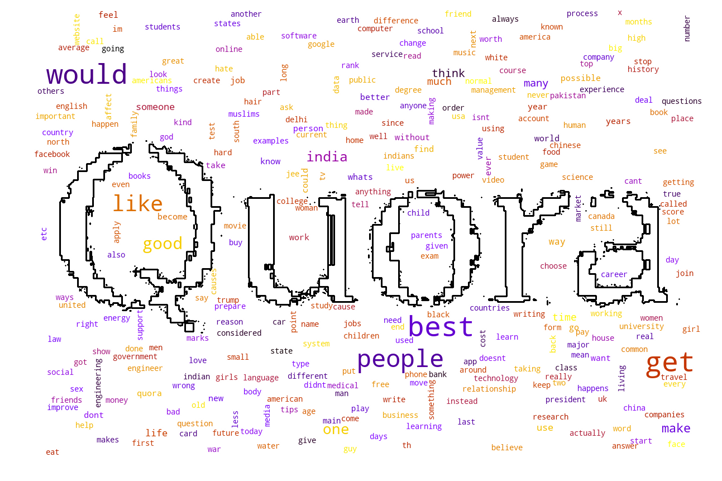

In [11]:
print('Train wordcloud')
m = stats_train['vocab'][['word','frequency']].apply(lambda x: [x['word'], x['frequency']], axis='columns')
freqs = { k: v for k,v in m.values if k not in stopwords.words('english') }
generate_wordcloud(freqs)

> We see a ton of not-so-useful words like people, would, good, etc, so the word cloud is not very interesting.

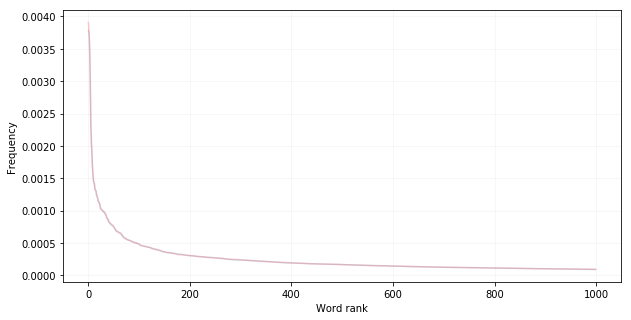

In [12]:
x = np.arange(1000)
y = stats_train['vocab'][stats_train['vocab'].stopword.isnull()].frequency.sort_values(ascending=False)[:1000]
y2 = stats_test['vocab'][stats_test['vocab'].stopword.isnull()].frequency.sort_values(ascending=False)[:1000]

fig, ax = plt.subplots(1,1,figsize=(10,5))
_ = ax.plot(x, y, alpha=0.2)
_ = ax.plot(x, y2, color='red', alpha=0.2)
_ = ax.grid(color='lightgrey', alpha=0.2)
_ = ax.set_xlabel('Word rank')
_ = ax.set_ylabel('Frequency')

>  The frequency curve above 0.0005 is steep, so it might be more interesting to look at a word cloud after filtering out those words. 

Train wordcloud, freq < 0.0005


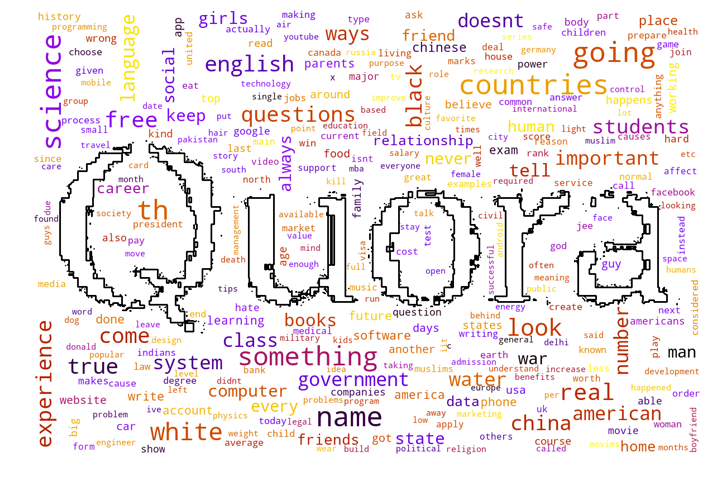

In [13]:
print('Train wordcloud, freq < 0.0005')
m = stats_train['vocab'][['word','frequency']].apply(lambda x: [x['word'], x['frequency']], axis='columns')
freqs = { k: v**3 for k,v in m.values if k not in stopwords.words('english') if v < 0.0005 }
generate_wordcloud(freqs)

> With filtering the word cloud is a little more interesting. Here I am also magnifying the difference in frequencies for the words so that the top words stand out a little more.

In [14]:
stats_test['topwords'][['word','frequency']][:10]

,word,frequency
103,get,0.003909
25,best,0.003817
31,would,0.003647
62,people,0.003422
48,like,0.002852
305,good,0.002329
77,one,0.002096
216,india,0.001919
838,make,0.001699
294,think,0.001576


Test wordcloud, freq < 0.0005


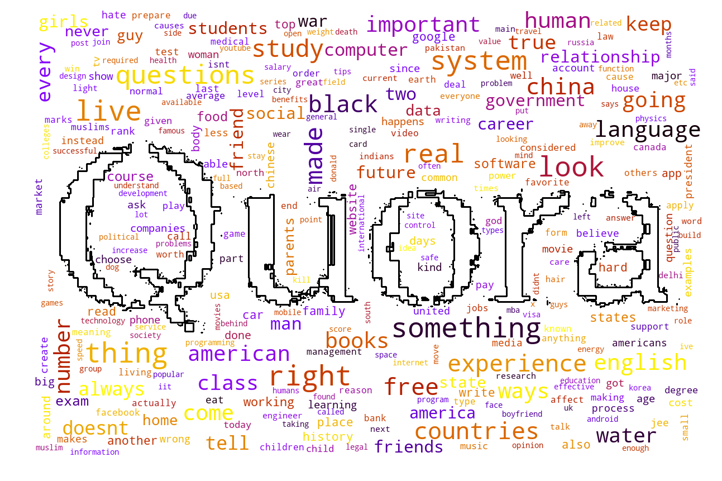

In [15]:
print('Test wordcloud, freq < 0.0005')
m = stats_test['vocab'][['word','frequency']].apply(lambda x: [x['word'], x['frequency']], axis='columns')
freqs = { k: v**3 for k,v in m.values if k not in stopwords.words('english') if v < 0.0005 }
generate_wordcloud(freqs)

> This is a much more interesting visualization. There are a lot of words related to school, such as books, study, students, etc. I'll do one more visualization with the training dataset and darker colors.

Train wordcloud, freq < 0.0005


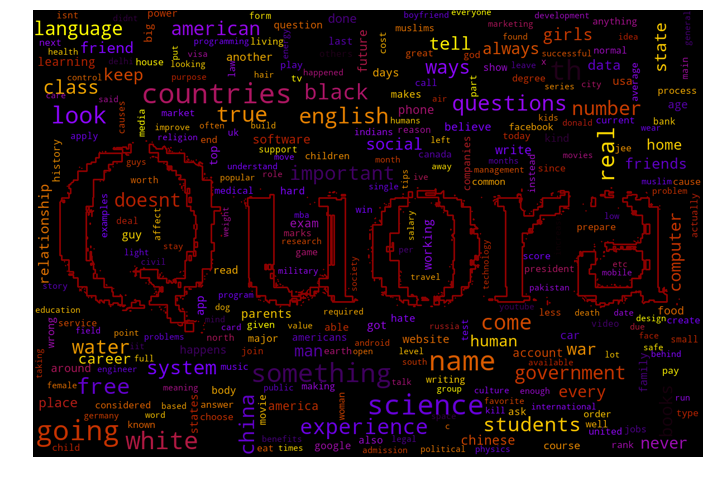

In [21]:
print('Train wordcloud, freq < 0.0005')
m = stats_train['vocab'][['word','frequency']].apply(lambda x: [x['word'], x['frequency']], axis='columns')
freqs = { k: v**3 for k,v in m.values if k not in stopwords.words('english') if v < 0.0005 }
generate_wordcloud(freqs, colormap='gnuplot', background_color='black', contour_color='darkred')

> There is a good method to discover the importance of a word: inverse doc frequency. I have already calculated it from the gather_stats function. These are words that actually don't appear in many of the documents. The ordering for this metric ends up being the same thing as total number of documents that a word appears in. The size of words in the word cloud should be based on the IDF metric, rather than the number of documents. I'm filtering to words that show up in at least .04% of documents because that is when the gradient of the IDF curve starts to level out (see below). Below that frequency there are a lot of misspellings.

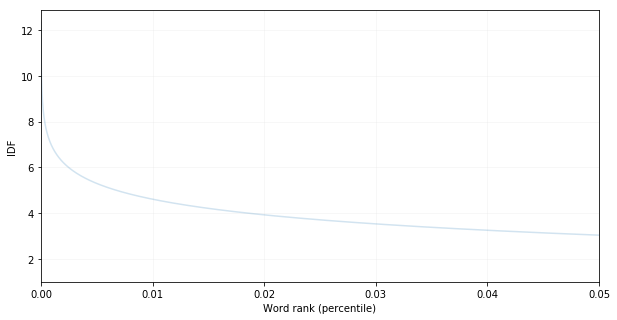

In [17]:
df_train = stats_train['vocab'].sort_values(by='doc_freq', ascending=True)

x1 = df_train[df_train.stopword.isnull()].doc_freq
y1 = df_train[df_train.stopword.isnull()].idf.sort_values(ascending=False)

fig, ax = plt.subplots(1,1,figsize=(10,5))
_ = ax.plot(x1, y1, alpha=0.2)
_ = ax.grid(color='lightgrey', alpha=0.2)
_ = ax.set_xlabel('Word rank (percentile)')
_ = ax.set_ylabel('IDF')
_ = ax.set_xlim(0, 0.05)

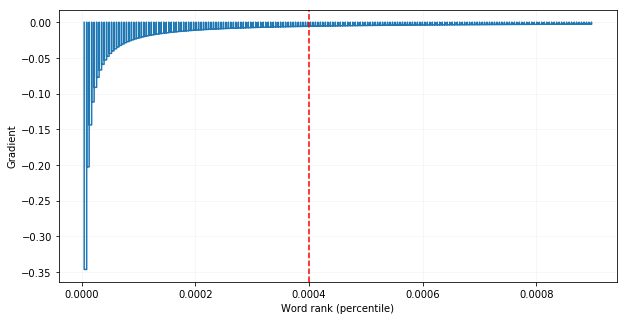

In [18]:
df_train = stats_train['vocab'].sort_values(by='doc_freq', ascending=True)

x1 = df_train[df_train.stopword.isnull()].doc_freq
x2 = x1[x1 < 0.0009]
y2 = np.gradient(y1)[x1 < 0.0009]

fig, ax = plt.subplots(1,1,figsize=(10,5))
_ = ax.plot(x2, y2)
_ = ax.grid(color='lightgrey', alpha=0.2)
_ = ax.set_xlabel('Word rank (percentile)')
_ = ax.set_ylabel('Gradient')
_ = ax.axvline(0.0004, color='red', linestyle='--')

Train wordcloud, IDF (rare/important words)


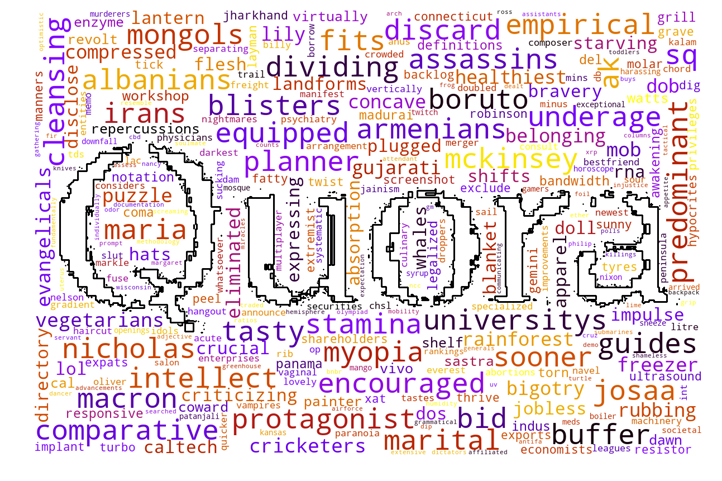

In [19]:
print('Train wordcloud, IDF (rare/important words)')
df_train = stats_train['vocab']
df_train = df_train[df_train.doc_freq >= 0.0004 ] # must appear in at least 1% of documents
m = df_train[['word','idf']].apply(lambda x: [x['word'], x['idf']], axis='columns')
freqs = { k: v**3 for k,v in m.values if k not in stopwords.words('english') }
generate_wordcloud(freqs)

In [20]:
df_train.sort_values(by='idf', ascending=False)[:10]

,word,vocab,stopword,frequency,doc_counts,idf,doc_freq
631,sq,96,NaN,0.000006,92,7.817617,0.000403
14849,discard,93,NaN,0.000006,92,7.817617,0.000403
4528,irans,93,NaN,0.000006,92,7.817617,0.000403
14264,marital,93,NaN,0.000006,92,7.817617,0.000403
20699,bigotry,95,NaN,0.000006,92,7.817617,0.000403
28865,landforms,92,NaN,0.000006,92,7.817617,0.000403
7281,macron,93,NaN,0.000006,92,7.817617,0.000403
11861,planner,97,NaN,0.000006,92,7.817617,0.000403
28730,crucial,92,NaN,0.000006,92,7.817617,0.000403
14754,cleansing,93,NaN,0.000006,92,7.817617,0.000403


> There are a lot of political words in there and some generally negative words, which leads me to believe that negative / devisive content is going to be pretty rare. 